In [1]:
import time, cv2, os, sys
sys.path.append('..')
import numpy as np
import tensorflow as tf
from utils import *
from matplotlib import pyplot as plt
tf.set_random_seed(777)

In [2]:
tmp = np.load('/data1/jerry/project/deblurring/data/same_sig/new_data_128_easy_3_shuffle.npz')

img = tmp['data']
lab = tmp['label']

print('Input Size : %s'%str(img.shape))
print('Label Size : %s'%str(lab.shape))


Input Size : (3588, 128, 128)
Label Size : (3588, 128, 128)


In [3]:
idx = []
cnt = []
for i, d in enumerate(img):
    tmp = (d!=0).sum()
    if tmp > 16382 : 
        cnt.append(tmp)
        idx.append(i)
idx = np.array(idx)
#print(idx)    
    

In [4]:
def preproc(img):
    if len(img.shape) == 2:
        tmp_img = np.reshape(img, [1, img.shape[0], img.shape[1]])
    else :
        tmp_img = img
        
    n, h, w = tmp_img.shape
    new_data = np.zeros([n, h+2,w+2])
    new_data[:,1:-1,1:-1] = tmp_img
    out = np.zeros([n, h*w, 9])
    cnt = 0
    for i in range(h):
        for j in range(w):
            out[:,cnt,:] = np.reshape(new_data[:,i:i+3, j:j+3], [-1, 9])
            cnt += 1
    return out

In [5]:
out = preproc(img)

In [6]:
class Model:

    def __init__(self, sess, name, size, lr):
        self.sess = sess
        self.name = name
        self.size = size
        self.lr = lr
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name, values=[self.size, self.lr]):
            
            # input place holders
            self.X = tf.placeholder(tf.float32, shape = [None, self.size*self.size, 9])
            # img 64x64x1 (gray scale)
            self.Y = tf.placeholder(tf.float32, shape = [None, self.size, self.size])
            
            self.keep = tf.placeholder(tf.float32)
            
            
            # L1 ImgIn shape = (?, node)
            w1 = init_w('w1', [1, self.size*self.size, 9])
            #b1 = init_b('b1', [1, self.size, self.size, 1])
            L1 = tf.reduce_sum(tf.multiply(self.X, w1), axis = 2)            
            self.logits = tf.reshape(L1, [-1, self.size, self.size])
            

        # define cost/loss & optimizer
        #beta = 0.01
        #self.regularizers = tf.nn.l2_loss(w1)# + tf.nn.l2_loss(w2)
        self.cost = tf.reduce_mean(tf.square(self.logits-self.Y))# + beta*self.regularizers)
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.lr).minimize(self.cost)
    
    def _cost(self, x_data, y_data, keep = 0.7):
        return self.sess.run(self.cost, feed_dict={
            self.X: x_data, self.Y: y_data, self.keep: keep})
    
    def train(self, x_data, y_data, keep = 0.7):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.keep: keep})
    
    def predict(self, x_test, keep = 1.0):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep: keep})

In [7]:
sess = tf.Session()
deblur = Model(sess, "deblur", 128, 1e-4)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, '/data1/jerry/project/deblurring/checkpoint/deblurring01/locally')

INFO:tensorflow:Restoring parameters from /data1/jerry/project/deblurring/checkpoint/deblurring01/locally


In [8]:
val_tr_cost = []
val_te_cost = []

In [ ]:
start = time.time()
epochs = 1000
batch = 100
for epoch in range(epochs):
    avg_train_cost = 0
    avg_test_cost = 0
    total_batch = int(len(idx)/batch)

    for i in range(total_batch):
        
        tr_batch_seq = np.random.choice(len(idx), batch, replace=False)
        batch_xs = out[idx[tr_batch_seq]]
        batch_ys = lab[idx[tr_batch_seq]]
        c, _ = deblur.train(batch_xs, batch_ys)
        avg_train_cost += c/total_batch
    
        te_batch_seq = np.random.choice(len(img), batch, replace=False)
        test_c = deblur._cost(out[te_batch_seq], lab[te_batch_seq])

        avg_test_cost += test_c / total_batch
        val_tr_cost.append(avg_train_cost)
        val_te_cost.append(avg_test_cost)

    
    
    if (epoch+1)%10 == 0:
        tr_batch_seq = np.random.choice(len(idx), 1, replace=False)
        test_tr = deblur.predict(out[[idx[tr_batch_seq[0]]]])
        te_batch_seq = np.random.choice(len(img), 1, replace=False)
        test_te = deblur.predict(out[te_batch_seq])
        print("Epoch  : %d/%d"%(epoch+1, epochs))
        print("Train Cost : %.9f"%(avg_train_cost))
        print("Test Cost  : %.9f"%(avg_test_cost))
        print("----------------------------\n\n")
        plt.figure(figsize=(20, 10))

        plt.subplot(2,6,1)
        plt.title("Input")
        plt.imshow(img[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,2)
        plt.title("Inference")
        plt.imshow(test_tr[0,:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,3)
        plt.title("Label")
        plt.imshow(lab[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,4)
        plt.title("Infer - Input")
        plt.imshow(test_tr[0,:,:] - img[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,5)
        plt.title("Label - Input")
        plt.imshow(lab[idx[tr_batch_seq[0]],:,:] - img[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,6)
        plt.title("Label - Infer")
        plt.imshow(lab[idx[tr_batch_seq[0]],:,:] - test_tr[0,:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        
        plt.subplot(2,6,7)
        plt.title("Input")
        plt.imshow(img[te_batch_seq[0],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,8)
        plt.title("Inference")
        plt.imshow(test_te[0,:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,9)
        plt.title("Label")
        plt.imshow(lab[te_batch_seq[0],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,10)
        plt.title("Infer - Input")
        plt.imshow(test_te[0,:,:] - img[te_batch_seq[0],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,11)
        plt.title("Label - Input")
        plt.imshow(lab[te_batch_seq[0],:,:] - img[te_batch_seq[0],:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        plt.subplot(2,6,12)
        plt.title("Label - Infer")
        plt.imshow(lab[te_batch_seq[0],:,:] - test_te[0,:,:], cmap=plt.cm.bone, vmin=0, vmax=1)
        
        plt.show()
print("Learning Finished!")
print("Elapsed time : ", time.time()-start)

In [ ]:
saver.save(sess, '/data1/jerry/project/deblurring/checkpoint/deblurring01/locally')

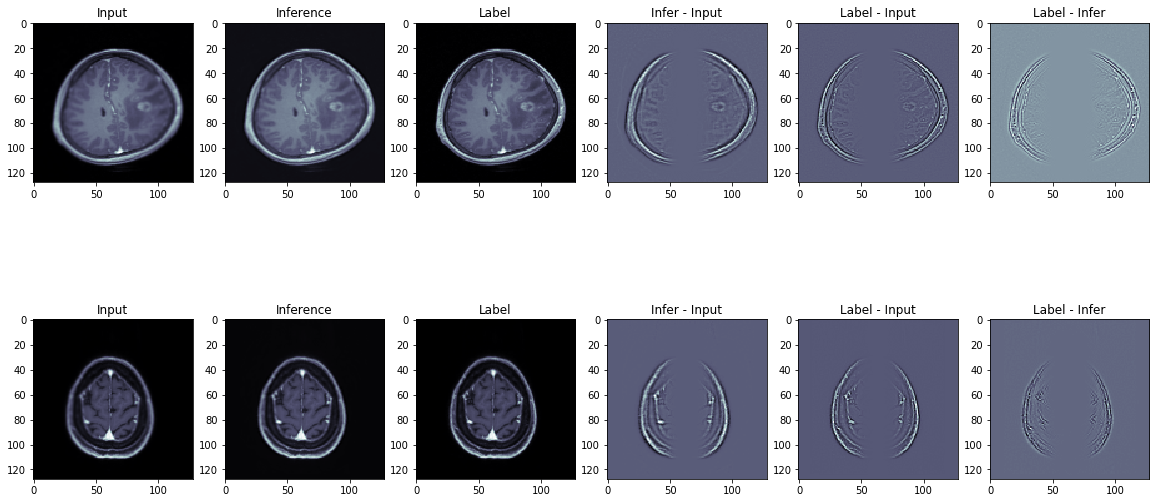

In [11]:
tr_batch_seq = np.random.choice(len(idx), 1, replace=False)
test_tr = deblur.predict(out[[idx[tr_batch_seq[0]]]])
te_batch_seq = np.random.choice(len(img), 1, replace=False)
test_te = deblur.predict(out[te_batch_seq])
plt.figure(figsize=(20, 10))

plt.subplot(2,6,1)
plt.title("Input")
plt.imshow(img[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,2)
plt.title("Inference")
plt.imshow(test_tr[0,:,:], cmap=plt.cm.bone)
plt.subplot(2,6,3)
plt.title("Label")
plt.imshow(lab[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,4)
plt.title("Infer - Input")
plt.imshow(test_tr[0,:,:] - img[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,5)
plt.title("Label - Input")
plt.imshow(lab[idx[tr_batch_seq[0]],:,:] - img[idx[tr_batch_seq[0]],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,6)
plt.title("Label - Infer")
plt.imshow(lab[idx[tr_batch_seq[0]],:,:] - test_tr[0,:,:], cmap=plt.cm.bone)

plt.subplot(2,6,7)
plt.title("Input")
plt.imshow(img[te_batch_seq[0],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,8)
plt.title("Inference")
plt.imshow(test_te[0,:,:], cmap=plt.cm.bone)
plt.subplot(2,6,9)
plt.title("Label")
plt.imshow(lab[te_batch_seq[0],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,10)
plt.title("Infer - Input")
plt.imshow(test_te[0,:,:] - img[te_batch_seq[0],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,11)
plt.title("Label - Input")
plt.imshow(lab[te_batch_seq[0],:,:] - img[te_batch_seq[0],:,:], cmap=plt.cm.bone)
plt.subplot(2,6,12)
plt.title("Label - Infer")
plt.imshow(lab[te_batch_seq[0],:,:] - test_te[0,:,:], cmap=plt.cm.bone)

plt.show()